```
This notebook runs small ensembles in the Oslo fjord where we perturb a
single parameter for each ensemble to look at the resulting variance 
and how it affects a drift trajectory.

Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 711902d818931f354021a809b5b19626dc97837e on branch reduced_gravity


In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display
import xarray as xr


#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [4]:
%cuda_context_handler gpu_ctx

### 1D integration

In [5]:
h = 10*np.ones(50)
hu = -10*np.cos(np.linspace(0,2*np.pi,50))

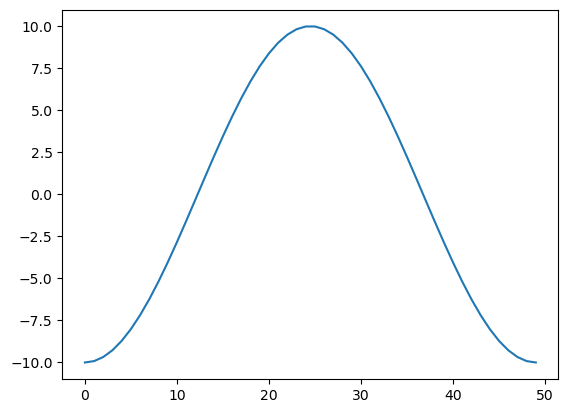

In [6]:
plt.plot(hu)

In [7]:
for i in range(49):
    h[i+1] = (hu[i]*0.1)/h[i] + h[i]


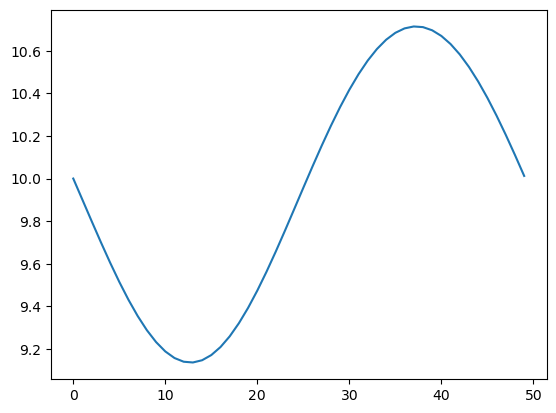

In [8]:
plt.plot(h)

### 2D integration

In [9]:
h = 10*np.ones((50,50))
hu = np.tile(-10*np.cos(np.linspace(0,2*np.pi,50))[:, np.newaxis],50)
hv = np.tile(-10*np.cos(np.linspace(0,2*np.pi,50))[:, np.newaxis],50)

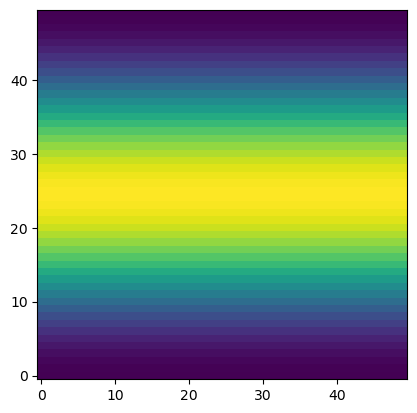

In [10]:
plt.imshow(hu)

In [11]:
for i in range(49):
    h[i+1] = (hu[i]*0.1)/h[i] + h[i]
for i in range(49):
    h[:,i+1] = (hv[:,i]*0.1)/h[:,i] + h[:,i]

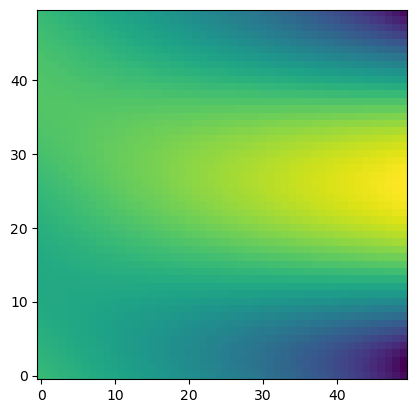

In [12]:
plt.imshow(h)

## Reconstruction

In [13]:
nx = 500
ny = 500
dx = 100
dy = 100

g = 9.81,
f = 0.0012

H_const = 10

dataShape = (ny + 4, nx + 4)
dataShapeH = (ny + 5, nx + 5)

eta0 = np.zeros(dataShape, dtype=np.float32)
hu0  = np.zeros(dataShape, dtype=np.float32)
hv0  = np.zeros(dataShape, dtype=np.float32)

Hi = np.ones(dataShapeH, dtype=np.float32)*H_const


def add_bump(x_bump, y_bump, a, b):
    X = np.arange(start=0.5*dx, stop=nx*dx , step=dx) - x_bump
    Y = np.arange(start=0.5*dy, stop=ny*dy , step=dy) - y_bump
    YY, XX = np.meshgrid(X, Y)

    etaBump = a*np.exp(-b*(XX*XX + YY*YY))
    eta0[2:-2, 2:-2] += etaBump

    DetaDX = -a*2*b*XX*np.exp(-b*(XX*XX + YY*YY))
    DetaDY = -a*2*b*YY*np.exp(-b*(XX*XX + YY*YY))

    hu0[2:-2,2:-2] += -(g*(etaBump + H_const)/f)*DetaDX
    hv0[2:-2,2:-2] += (g*(etaBump + H_const)/f)*DetaDY


add_bump(nx*dx/2, ny*dy/2, 1, 1e-8)

In [14]:
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(20,7), interior=False, eta_lim = 15, uv_lim=5):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    range_eta = eta_lim
    range_huv = uv_lim
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=0, vmax=range_eta)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=0, vmax=range_eta)
    axs[0].set_title("$h$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$u$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$v$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)

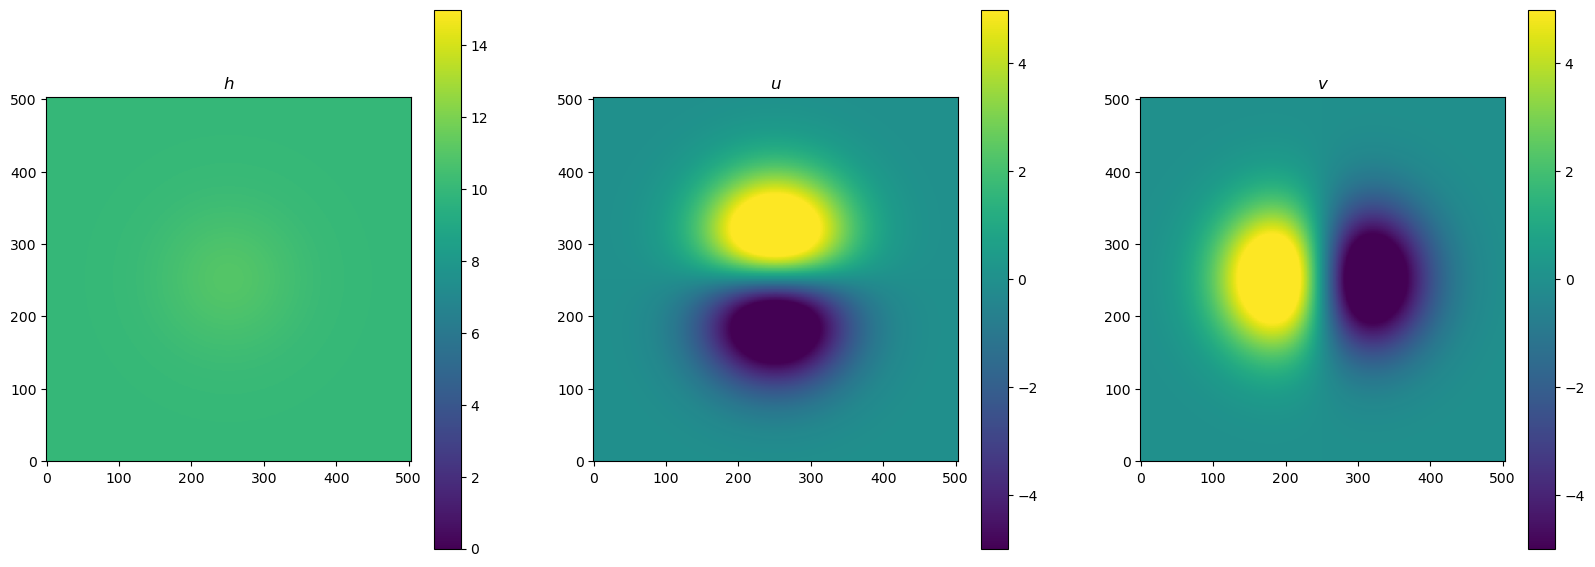

In [15]:
imshow3(H_const+eta0, hu0, hv0)

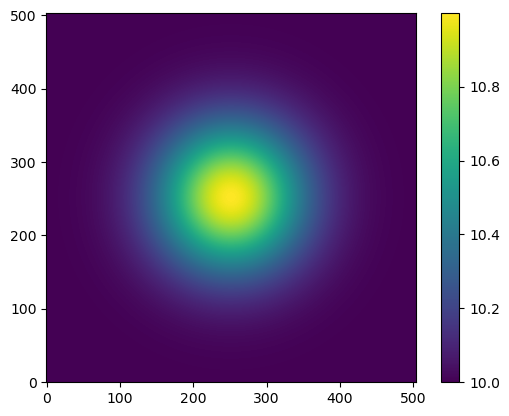

In [16]:
plt.imshow(H_const+eta0)
plt.colorbar()

In [17]:
h = H_const*np.ones_like(eta0) 
hu = hu0
hv = hv0

In [18]:
for i in range(ny):
    h[i+1] = (hu[i]*dy)*f/g/h[i] + h[i]
for i in range(nx):
    h[:,i+1] = (hv[:,i]*dx)*f/g/h[:,i] + h[:,i]


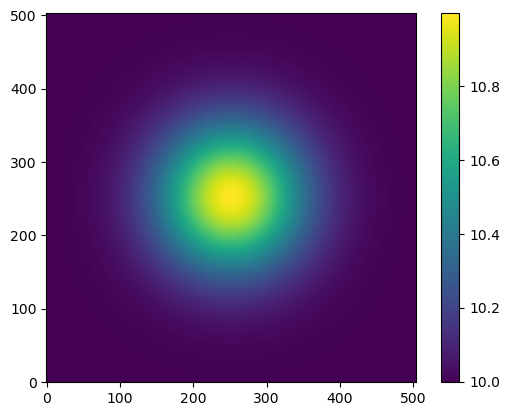

In [19]:
plt.imshow(h)
plt.colorbar()

### Oslofjord

In [275]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"
# source_url = "/lustre/storeB/project/fou/hi/FjordOs/geogrid_tmp/test_polstere_1h_0007.nc"
nc = Dataset(source_url)
ds = xr.open_dataset(source_url)

# Grid and discretization
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [276]:
_, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1022.0, timestep_indices=[[140]], norkyst_data=False, land_value=0.0, download_data=False)


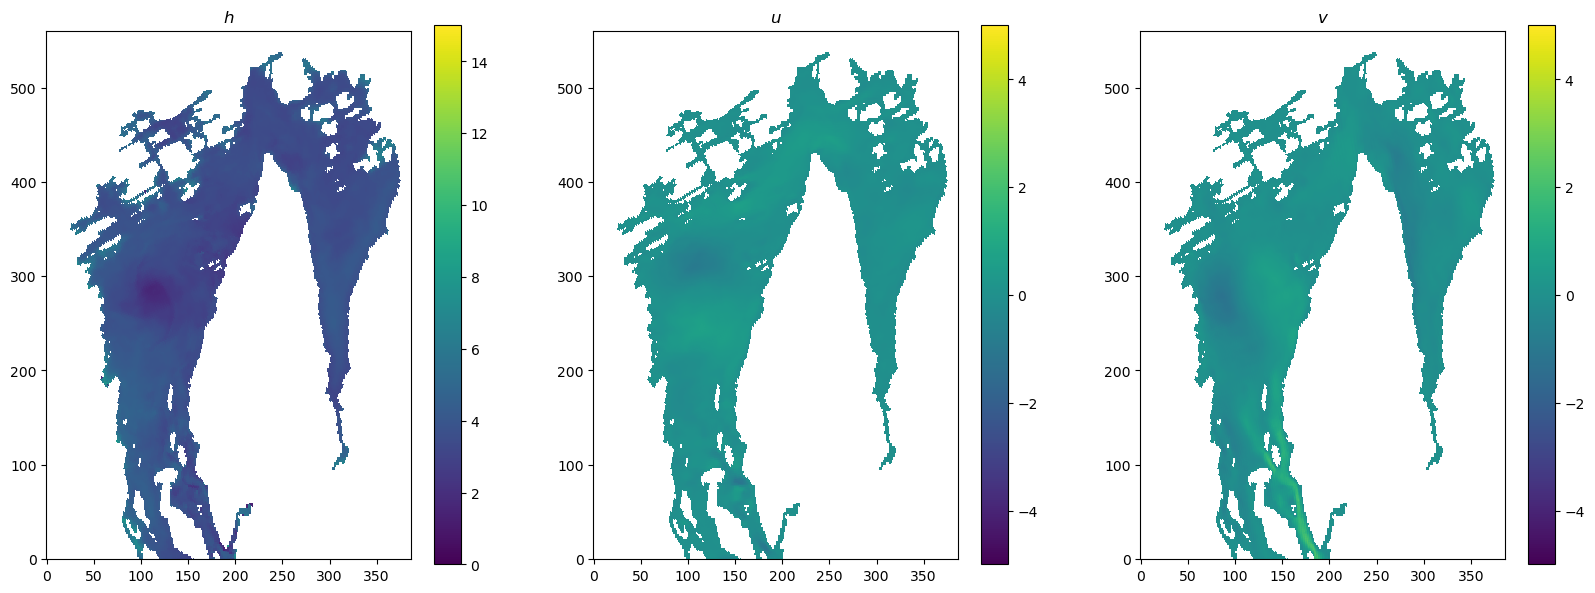

In [277]:
imshow3(baroclinic_data_args["eta0"], baroclinic_data_args["hu0"], baroclinic_data_args["hv0"])

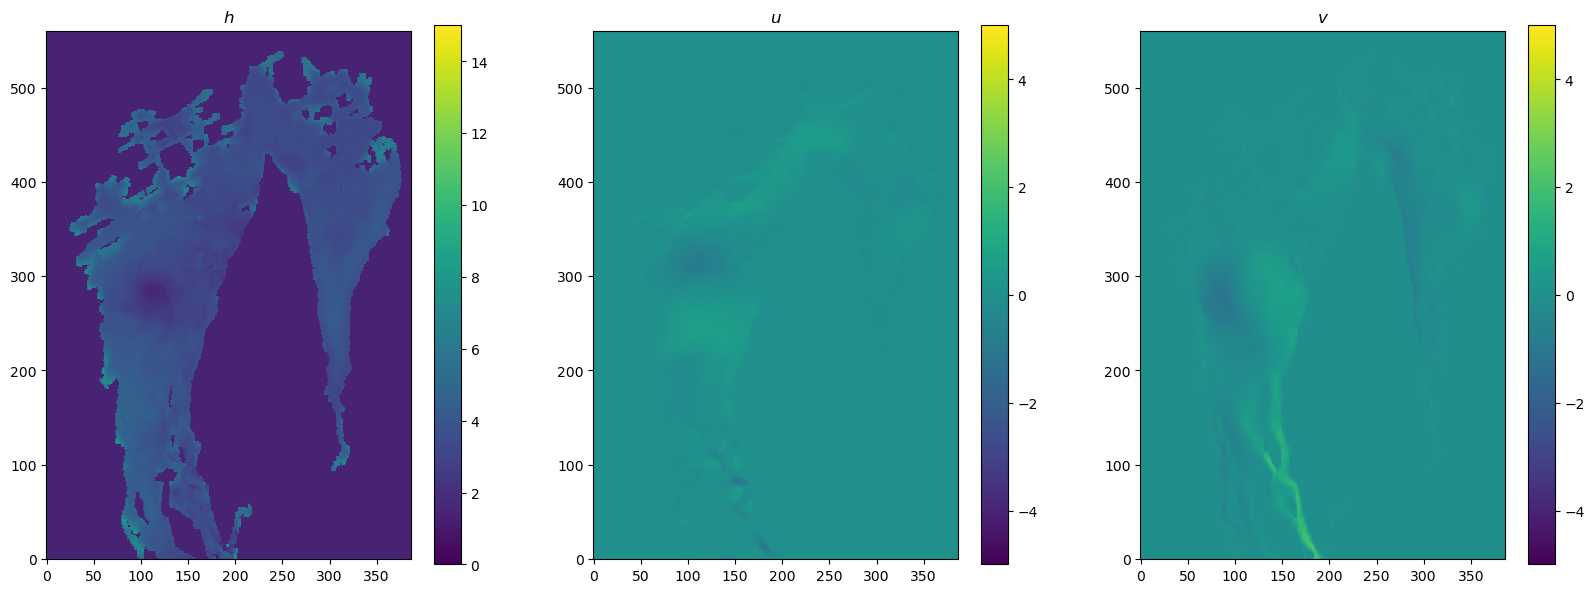

In [278]:
imshow3(baroclinic_data_args["eta0"].data, baroclinic_data_args["hu0"].data, baroclinic_data_args["hv0"].data)

In [283]:
nx = baroclinic_data_args["nx"] + 4
ny = baroclinic_data_args["ny"] + 4 

dx = baroclinic_data_args["dx"]
dy = baroclinic_data_args["dy"]

In [281]:
g = baroclinic_data_args["g"]

In [282]:
f, _ = OceanographicUtilities.calcCoriolisParams(baroclinic_data_args["latitude"])

In [351]:
h = copy.deepcopy(baroclinic_data_args["eta0"])
hu = copy.deepcopy(baroclinic_data_args["hu0"])
hv = copy.deepcopy(baroclinic_data_args["hv0"])


In [352]:
u = hu/h
v = hv/h

In [333]:
# for i in range(ny):
#     h[i+1] = (hu[i]*dy)*f/g/h[i] + h[i]
# for i in range(nx):
#     h[:,i+1] = (hv[:,i]*dx)*f/g/h[:,i] + h[:,i]


In [376]:
frac = 0.5
for iter in range(25):
    print(iter)
    for i in range(ny-1):
        for j in range(nx-1): 
            if not np.ma.is_masked(h[i+1,j]):
                if not np.ma.is_masked(h[i,j]):
                    h[i+1,j] = frac*((u[i,j]*dy)*f[i,j]/g + h[i,j]) + (1-frac)*h[i+1,j]

    for i in range(nx-1):
        for j in range(ny-1):
            if not np.ma.is_masked(h[j,i+1]):
                if not np.ma.is_masked(h[j,i]):         
                    h[j,i+1] = frac*(-(v[j,i]*dx)*f[j,i]/g + h[j,i]) + (1-frac)*h[j,i+1]



    for i in range(1,ny):
        for j in range(1,nx): 
            if not np.ma.is_masked(h[i-1,j]):
                if not np.ma.is_masked(h[i,j]):
                    h[i-1,j] = frac*(-(u[i,j]*dy)*f[i,j]/g + h[i,j]) + (1-frac)*h[i-1,j]
    
    for i in range(1, nx):
        for j in range(1, ny):
            if not np.ma.is_masked(h[j,i-1]):
                if not np.ma.is_masked(h[j,i]):         
                    h[j,i-1] = frac*((v[j,i]*dx)*f[j,i]/g + h[j,i]) + (1-frac)*h[j,i-1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


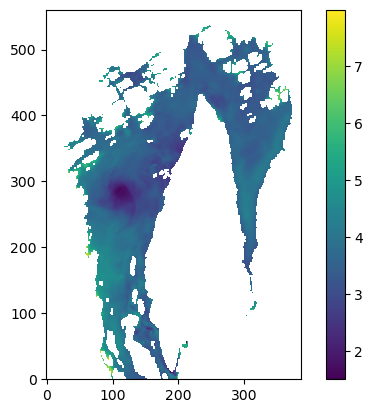

In [384]:
plt.imshow(baroclinic_data_args["eta0"])
plt.colorbar()

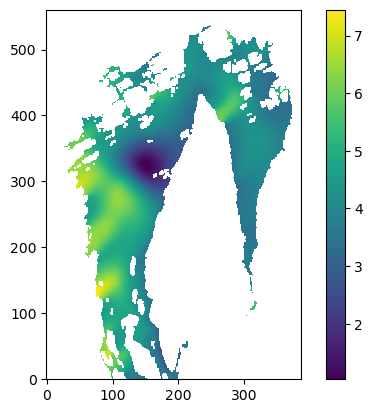

In [372]:
plt.imshow(h)
plt.colorbar()

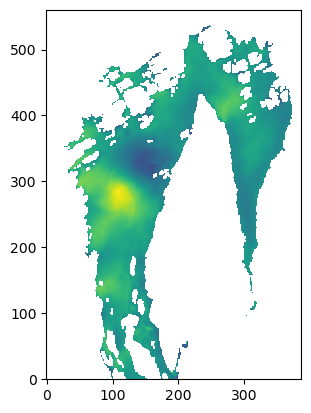

In [373]:
plt.imshow(h-baroclinic_data_args["eta0"])

-0.10628352671304891 0.1250675729543652


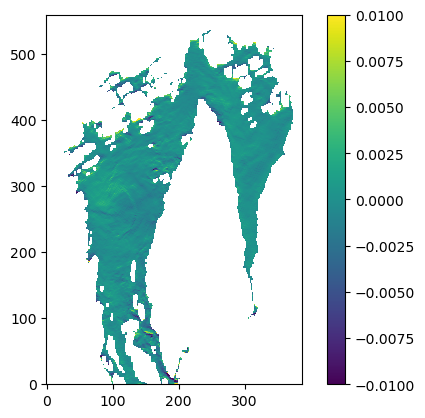

In [374]:

geo_bal_y = (baroclinic_data_args["eta0"][1:]-baroclinic_data_args["eta0"][:-1])/dx - (f[1:]+f[:-1])/2/g*(v[1:]+v[:-1])/2
print(geo_bal_y.min(), geo_bal_y.max())
plt.imshow(geo_bal_y, vmin=-0.01, vmax=0.01)
plt.colorbar()

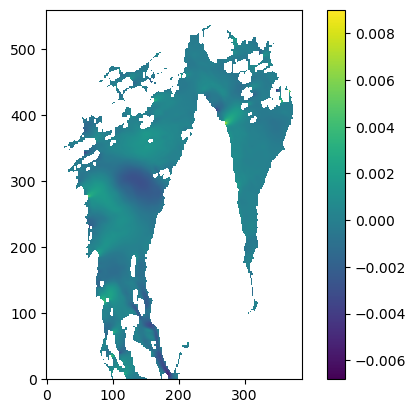

In [375]:
plt.imshow((h[1:]-h[:-1])/dx - (f[1:]+f[:-1])/2/g*(v[1:]+v[:-1])/2, vmin=-0.01, vmax=0.01)
plt.colorbar()

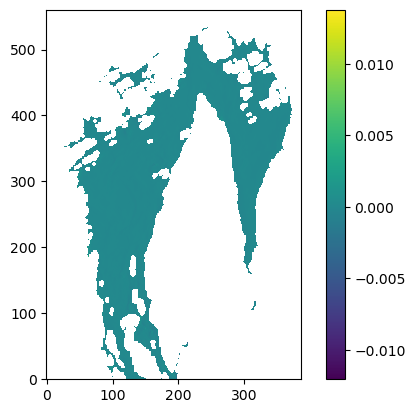

In [358]:
OceanographicUtilities.calcGeostrophicBalance(baroclinic_data_args["eta0"], 0.0*np.ones_like(h), hu, hv, 
                                              baroclinic_data_args["angle"], baroclinic_data_args["f"], dx, dy, g=g, use_minmod=False, minmod_theta=1.3, norkyst=False)[0][1plt.imshow( ] )
plt.colorbar()

In [377]:
data_args = copy.deepcopy(baroclinic_data_args)
data_args["eta0"] = h 

In [378]:
ref_wind = data_args["wind"]
ref_wind.wind_u[ref_wind.wind_u > 1e3] = 0.0
ref_wind.wind_v[ref_wind.wind_v > 1e3] = 0.0
ref_wind.compute_wind_stress_from_wind()

data_args["wind"] = ref_wind
data_args["wind_stress_factor"] = 0.5

In [379]:
sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(data_args),  dt=0.0)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [380]:
sim.step(3600)

3600.0

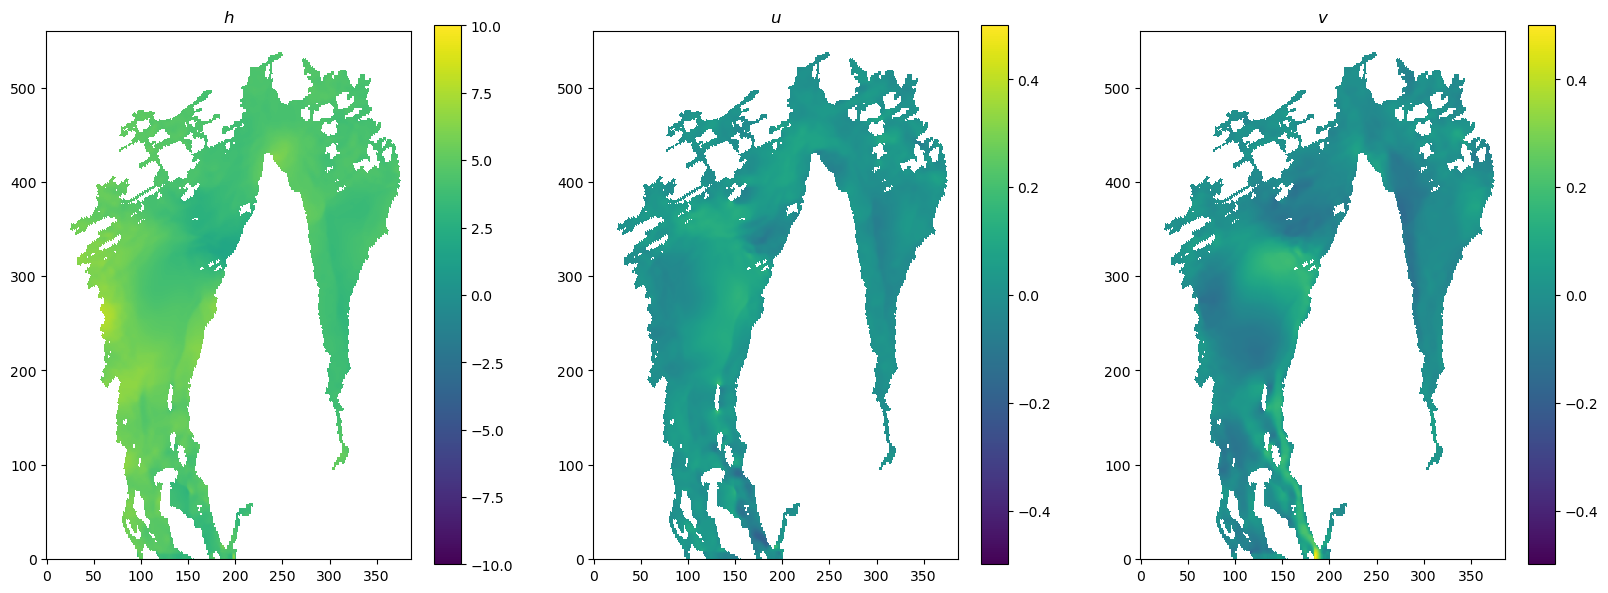

In [383]:
eta, hu, hv = sim.download()

u = hu/eta
v = hv/eta
imshow3(eta, u, v)

In [382]:
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(20,7), interior=False, eta_lim = 10, uv_lim=0.5):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    range_eta = eta_lim
    range_huv = uv_lim
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$h$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$u$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$v$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)

### Iteration

In [239]:
nx = 500
ny = 500
dx = 100
dy = 100

g = 9.81
f = 0.0012

H_const = 10

dataShape = (ny + 4, nx + 4)
dataShapeH = (ny + 5, nx + 5)

eta0 = np.zeros(dataShape, dtype=np.float32)
hu0  = np.zeros(dataShape, dtype=np.float32)
hv0  = np.zeros(dataShape, dtype=np.float32)

Hi = np.ones(dataShapeH, dtype=np.float32)*H_const

add_bump(nx*dx/2, ny*dy/2, 1, 1e-8)

In [260]:
h = H_const*np.ones_like(eta0)
u = hu0/(H_const + eta0)
v = hv0/(H_const + eta0)

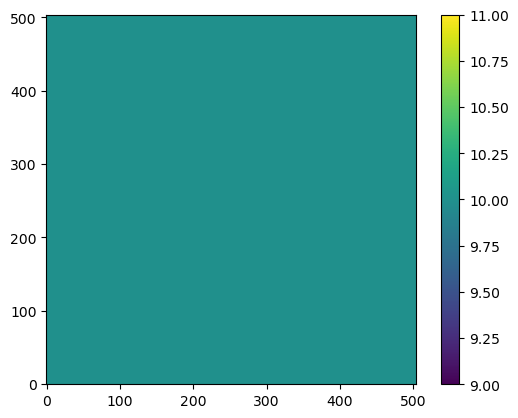

In [261]:
plt.imshow(h)
plt.colorbar()

In [267]:
# for iter in range(1000):
#     tmp_h  =  h[:-1] - f*u[:-1]*dy/g
#     h[:-1]  =  tmp_h + f*u[1:]*dy/g

#     tmp_h  =  h[:,:-1] + f*v[:,:-1]*dx/g
#     h[:,:-1]  =  tmp_h - f*v[:,1:]*dx/g

In [265]:
for iter in range(1000):
    tmp_h1  =  h[:-1] - f*u[:-1]*dy/g
    tmp_h2  =  h[1:] + f*u[1:]*dy/g
    h[0] = tmp_h1[0]
    h[1:-1] = (tmp_h1[1:] + tmp_h2[:-1])/2
    h[-1] = tmp_h2[-1]

    tmp_h1  =  h[:,:-1] + f*v[:,:-1]*dx/g
    tmp_h2  = h[:,1:] - f*v[:,1:]*dx/g
    h[:,0] = tmp_h1[:,0]
    h[:,1:-1] = (tmp_h1[:,1:] + tmp_h2[:,:-1])/2
    h[:,-1] = tmp_h2[:,-1]


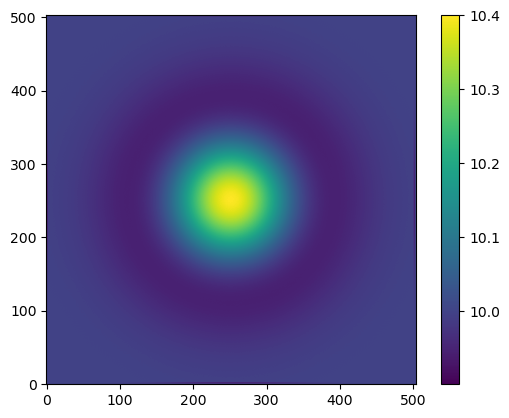

In [268]:
plt.imshow(h)
plt.colorbar()

### Iterative Oslofjord

In [181]:
h = copy.deepcopy(baroclinic_data_args["eta0"])
hu = copy.deepcopy(baroclinic_data_args["hu0"])
hv = copy.deepcopy(baroclinic_data_args["hv0"])

In [182]:
u = hu/h
v = hv/h

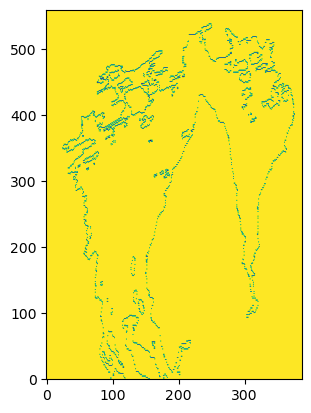

In [112]:
plt.imshow(h[1:].mask == h[:-1].mask)

In [100]:
h[1:]  =  h[:-1] + f[:-1]*u[:-1]*dy/g

In [102]:
h[:,1:]  =  h[:,:-1] + f[:,:-1]*v[:,:-1]*dx/g

In [103]:
for iter in range(20):
    h[1:]  =  h[:-1] + f[:-1]*u[:-1]*dy/g
    h[:,1:]  =  h[:,:-1] + f[:,:-1]*v[:,:-1]*dx/g

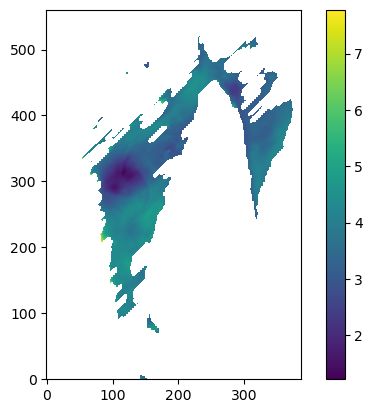

In [105]:
plt.imshow(h)
plt.colorbar()

In [ ]:
for i in range(ny-1):
    for j in range(nx-1): 
        if not np.ma.is_masked(h[i+1,j]) and not np.ma.is_masked(h[i,j]):
                h[i+1,j] = (hu[i,j]*dy)*f[i,j]/g/h[i,j] + h[i,j]

for i in range(nx-1):
    for j in range(ny-1):
         if not np.ma.is_masked(h[j,i+1]):
             if not np.ma.is_masked(h[j,i]):         
                h[j,i+1] = (hv[j,i]*dx)*f[j,i]/g/h[j,i] + h[j,i]

In [ ]:
def update_h(h0, u, v, f, g, dx=800, dy=800, x_dir=True, y_dir=True):
    h1 = np.zeros_like(h0)
    h1[:,:] = h0[:, :]

    ny, nx = h0.shape

    for y in range(2, ny-2):
        for x in range(2, nx-2):
            if not h0.mask[y, x]:
                # h0 is wet
                newh = 0
                num_wet_neighbours = 0
                
                if y_dir:
                    if not h0.mask[y-1, x]: 
                        # south is wet
                        num_wet_neighbours += 1
                        newh += h0[y-1, x] - (f[y,x]*u[y,x]*dy/g)

                    if not h0.mask[y+1, x]:
                        # north is wet
                        num_wet_neighbours += 1
                        newh += h0[y+1, x] + (f[y,x]*u[y,x]*dy/g)
                
                if x_dir:
                    if not h0.mask[y, x-1]:
                        # west is wet
                        num_wet_neighbours += 1
                        newh += h0[y, x-1] + (f[y,x]*v[y,x]*dx/g)
                    
                    if not h0.mask[y, x+1]:
                        # east is wet
                        num_wet_neighbours += 1
                        newh += h0[y, x+1] - (f[y,x]*v[y,x]*dx/g)
                
                if num_wet_neighbours > 0:
                    h1[y, x] = newh/num_wet_neighbours
                else:
                    h1[y, x] = h1[y, x]


    return h1

h1 = np.ones_like(h0)*10
for i in range(30):
    h1 = update_h(h1, u, v, f, 0.01, x_dir=True, y_dir=True)